## Load Packages

In [3]:
# Link to Drive
from google.colab import drive
drive.mount('/content/drive')

# Connect to Earth Engine
#import ee
#ee.Authenticate()
#ee.Initialize()

Mounted at /content/drive


In [5]:
!pip install geopandas
!pip install rioxarray
!pip install geojson
!pip install rasterstats
!pip install seaborn

import os
from glob import glob
import numpy as np
import pandas as pd
import geojson
import shapely as shp
from shapely.geometry import Polygon
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rioxr
import seaborn as sns
#import gdal

#!pip install geemap
#import geemap

  Using cached rioxarray-0.9.1.tar.gz (47 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for rioxarray: filename=rioxarray-0.9.1-py3-none-any.whl size=54611 sha256=4928777eab5cb0f30e5e10036e71132304854fe621f9f91510e1e438b370653c
  Stored in directory: /root/.cache/pip/wheels/07/da/9e/1cc57b2e7a29a206893db83e984a341e2e94378263e0798229
Successfully built rioxarray


## User-defined Functions

In [3]:
# Function to Mask Clouds
def maskCloud(image):
  cloudMask = image.select(['pixel_qa']).bitwiseAnd(1<<5).eq(0)
  cloudShadowMask = image.select(['pixel_qa']).bitwiseAnd(1<<3).eq(0)
  final_mask = cloudMask.And(cloudShadowMask)
  return image.updateMask(final_mask)

In [4]:
# Function to add water Index bands
def addIndex(image):
  ndwi = image.normalizedDifference(['green', 'nir']).rename(['ndwi'])
  # https://www.tandfonline.com/doi/abs/10.1080/01431169608948714
  
  mndwi = image.normalizedDifference(['green', 'swir1']).rename(['mndwi'])
  # https://www.tandfonline.com/doi/abs/10.1080/01431160600589179
  
  awei = image.expression("blue + 2.5*green - 1.5*(nir+swir1) - 0.25*swir2", {
    'blue': image.select(['blue']),
    'green': image.select(['green']),
    'nir': image.select(['nir']),
    'swir1': image.select(['swir1']),
    'swir2': image.select(['swir2'])
  }).rename(['awei'])
  # https://www.sciencedirect.com/science/article/pii/S0034425713002873
  
  wiFi = image.expression("1.7204 + 171*green +3*red - 70*nir - 45*swir1 - 71*swir2",{
    'green': image.select(['green']),
    'red': image.select(['red']),
    'nir': image.select(['nir']),
    'swir1': image.select(['swir1']),
    'swir2': image.select(['swir2'])
  }).rename(['wiFi'])
  # https://www.sciencedirect.com/science/article/abs/pii/S0034425715302753
  
  return image.addBands([ndwi, mndwi, awei, wiFi])


In [5]:
# Function of ostu's method
def otsu(histogram):
    counts = ee.Array(ee.Dictionary(histogram).get('histogram'))
    means = ee.Array(ee.Dictionary(histogram).get('bucketMeans'))
    size = means.length().get([0])
    total = counts.reduce(ee.Reducer.sum(), [0]).get([0])
    sum = means.multiply(counts).reduce(ee.Reducer.sum(), [0]).get([0])
    mean = sum.divide(total)

    indices = ee.List.sequence(1, size)

    def iFunc(i):
      aCounts = counts.slice(0, 0, i) 
      aCount = aCounts.reduce(ee.Reducer.sum(), [0]).get([0])
      aMeans = means.slice(0, 0, i)
      aMean = aMeans.multiply(aCounts).reduce(ee.Reducer.sum(),[0]).get([0]).divide(aCount)
      bCount = total.subtract(aCount)
      bMean = sum.subtract(aCount.multiply(aMean)).divide(bCount)
      return aCount.multiply(aMean.subtract(mean).pow(2)) \
            .add(bCount.multiply(bMean.subtract(mean).pow(2)))

    # Compute between sum of squares, where each mean partitions the data
    bss = indices.map(iFunc)

    return means.sort(bss).get([-1])

In [6]:
# Function of Otsu's Method
def thresholding(image):
  
  #waterIndex = index
  bands = ['ndwi', 'mndwi', 'awei', 'wiFi']

  #Compute the histogram of the NIR band. (the mean and variance are only FYI)
  hist_ndwi = image.select([bands[-1]]).reduceRegion(
      reducer = ee.Reducer.histogram().combine('mean', None, True).combine('variance', None, True),
      geometry = roi.getInfo(),
      scale = 30,
      maxPixels = 10e12,
      bestEffort = True)
  
  thrh_ndwi = otsu(hist_ndwi.get(bands[-1]+'_histogram'))

  watermask_ndwi = image.select([bands[-1]]).gt(thrh_ndwi).rename(['watermask_'+bands[-1]]).selfMask()
  
  #water = image.select([index]).lt(threshold)
  return image.addBands([watermask_ndwi]) \
              .clip(roi) \
              .copyProperties(image) \
              .set('system:time_start', ee.Date.fromYMD(image.get('year'), 12, 31))

In [7]:
def thresholding2(image):
  #indices = ['ndwi', 'mndwi', 'awei', 'wiFi']
  #indices = ['wiFi']
  indices = waterIndices

  histograms = [image.select([i]).reduceRegion(
      reducer = ee.Reducer.histogram().combine('mean', None, True).combine('variance', None, True),
      geometry = roi.getInfo(),
      scale = 30,
      maxPixels = 10e12,
      bestEffort = True) for i in indices]

  thrhs = [otsu(h.get(i+'_histogram')) for h,i in zip(histograms,indices)]

  watermasks = [image.select([i]).gt(t).rename(['watermask_'+i]).selfMask() for i,t in zip(indices,thrhs)]

  #.addBands([watermasks[0], watermasks[1], watermasks[2], watermasks[3]]) 
  return image.addBands(watermasks)\
              .clip(roi) \
              .copyProperties(image) \
              .set('system:time_start', ee.Date.fromYMD(image.get('year'), 12, 31))

## Load ROIs (Parcel)

In [8]:
# Load all parcels
os.chdir('/content/drive/MyDrive/THESIS_AQUAPONDS/ROI/Aquaculture_Asia_Coast_2019/Coastline_parcels_polygon')
path_parcels = glob(os.path.join(os.getcwd(), '*origin*.geojson'))[0]
parcels = gpd.read_file(path_parcels)[['fid', 'TARGET_FID', 'GID_0', 'NAME_0', 'Shape_Area', 'geometry']]
parcels.head()

,fid,TARGET_FID,GID_0,NAME_0,Shape_Area,geometry
0,1,215,JPN,Japan,7.774520e+10,"MULTIPOLYGON (((147.70812 43.07955, 146.24364 ..."
1,2,216,JPN,Japan,6.692903e+10,"MULTIPOLYGON (((143.48255 43.51240, 142.55864 ..."
2,3,627,BRN,Brunei,5.951115e+10,"MULTIPOLYGON (((114.95678 7.41797, 117.01525 5..."
3,4,628,BRN,Brunei,8.020112e+10,"MULTIPOLYGON (((116.07967 3.56603, 114.95462 2..."
4,5,629,IDN,Indonesia,7.967761e+10,"MULTIPOLYGON (((114.95462 2.72409, 114.47375 2..."


In [9]:
parcelIDs = range(len(parcels))
parcelIDs

range(0, 261)

In [10]:
#parcels.to_file('parcels.geojson', driver='GeoJSON')
with open('parcels.geojson') as f:
  parcels_geojson = geojson.load(f)

## GEE: Data Coverage Statistics ~ 1Y

### Preprocessing

In [ ]:
#import geemap.chart as chart

In [ ]:
#ROI = ee.FeatureCollection(parcels_geojson)
parcelID = parcelIDs[25]
ROI = ee.Geometry(parcels_geojson['features'][parcelID]['geometry'])#.bounds()
ROI.getInfo()

{'coordinates': [[[96.87263, 4.549847],
   [98.037118, 3.596584],
   [99.763169, 5.447578],
   [99.149891, 6.040032],
   [98.211756, 6.698248],
   [97.579619, 6.925182],
   [96.87263, 4.549847]]],
 'type': 'Polygon'}

In [ ]:
# Load Landsat Archives
ls8 = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR") \
        .filterDate('2013', '2020') \
        .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
        .filterBounds(ROI) \
        .sort("system:time_start", True)
ls7 = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR") \
      .filterDate('1999', '2020') \
      .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
      .filterBounds(ROI) \
      .sort("system:time_start", True)
ls5 = ee.ImageCollection("LANDSAT/LT05/C01/T1_SR") \
      .filterDate('1984', '2013') \
      .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
      .filterBounds(ROI) \
      .sort("system:time_start", True)
ls4 = ee.ImageCollection("LANDSAT/LT04/C01/T1_SR") \
      .filterDate('1984', '1994') \
      .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
      .filterBounds(ROI)\
      .sort("system:time_start", True)

# Merge Collections + Mask Cloud + Add water index bands
ls_all = ls8.merge(ls7).merge(ls5).merge(ls4)
ls_all = ls_all.sort('system:time_start', True).map(maskCloud).map(addIndex)

In [ ]:
# Count Observations at pixel level by year 
years = ee.List.sequence(1984, 2019)
counts = ee.ImageCollection.fromImages(years.map(lambda YEAR: 
            ls_all.select(['wiFi']).filter(ee.Filter.calendarRange(YEAR,YEAR,'year')).count().clip(ROI).set({'year':YEAR})))
type(counts)

ee.imagecollection.ImageCollection

In [ ]:
# Filter out years where no data are available
# Add "bandlength" as new property
counts_filtered = counts.map(lambda image: image.set('bandlength', image.bandNames().size()))
# Filter out the years where no data are available
counts_filtered = counts_filtered.filterMetadata('bandlength', 'not_equals', 0)
counts_filtered.size().getInfo()

33

### Test on 1Y

In [ ]:
#dc19 = ee.Image(counts.get(2)).select(['wiFi']).rename(['observations'])
dc19 = counts_filtered.first().select(['wiFi']).rename(['observations'])
# IMPORTANT: Set NA to 0 (otherwise neither histogram nor ee_to_numpy works)
dc19 = dc19.unmask(0)

type(dc19)
#dc19.getInfo()

ee.image.Image

In [ ]:
Map = geemap.Map(center=(20, 110), zoom=3)
Map.addLayer(ROI, {}, 'ROI')

vis = {'palette':["#ebedef", "#f6ddcc", "#f8c471", "#f4d03f", "#58d68d", \
                "#27ae60", "#1abc9c", "#3498db", "#2471a3", "#6c3483"], 'min':0, 'max':29}
#Map.addLayer(counts.filter(ee.Filter.eq('year',1987)), vis, '1987')
#Map.addLayer(counts.filter(ee.Filter.eq('year',2019)), vis, '2019')
Map.addLayer(dc19, vis, '2019')
Map

Map(center=[20, 110], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(To…

In [ ]:
#source = dc.toBands()
my_sample = dc19.sample(ROI, 1000)
property = 'observations'

options = {"title": 'Observation Counts in 2019',
          "xlabel": 'Numbers of Observation',
          "ylabel": 'Pixel count',
          "colors": ['#1d6b99']
          }

chart.feature_histogram(my_sample, property, minBucketWidth=1, **options)


In [ ]:
print(my_sample.first().getInfo())
print(my_sample.size().getInfo())
type(my_sample)

{'type': 'Feature', 'geometry': None, 'id': '0', 'properties': {'observations': 3}}
73380


ee.featurecollection.FeatureCollection

In [ ]:
# Get array out of feature collection property 'counts'
arr_dc19 = np.array(my_sample.aggregate_array('observations').getInfo())
arr_dc19 = np.asarray(np.unique(arr_dc19, return_counts=True))
arr_dc19

array([[    0,     1,     2,     3,     4,     5,     6,     7,     8,
            9,    10,    11,    12,    13],
       [17968,  4586, 10643, 13379, 10137,  8011,  3586,  1987,  1340,
          864,   363,   395,    85,    36]])

In [ ]:
np.round(arr_dc19[1][0]/np.sum(arr_dc19[1])*100, 1)

24.5

In [ ]:
#df_dc19 = pd.DataFrame({'observations': arr_dc19[0], 'counts': arr_dc19[1]})
#df_dc19

### All Years

In [ ]:
# Rename Property
dc = counts_filtered.map(lambda image: image.select(['wiFi']).rename(['observations']))
# IMPORTANT: Set NA to 0 (otherwise neither histogram nor ee_to_numpy works)
dc = dc.map(lambda image: image.unmask(0))
print(dc.size().getInfo())

# ImageCollection -> ee.List of images
dc_list = dc.toList(dc.size().getInfo())
type(dc_list)

33


ee.ee_list.List

In [ ]:
# Sample Image (pixel value ~ counts of observations) of Each Year (output ~ FeatureCollection)
my_sample = dc_list.map(lambda i: ee.Image(i).sample(ROI,1000))
# Aggregate Property "observations" values, Output as "ee.List"
arr_dc = my_sample.map(lambda i: ee.FeatureCollection(i).aggregate_array('observations'))
# "ee.List().getInfo()" Output "Python List"
arr_dc = np.array(arr_dc.getInfo()) # 
arr_dc

array([[ 0,  0,  0, ...,  1,  0,  0],
       [12, 10,  9, ...,  1,  1,  1],
       [16, 16, 15, ...,  4,  6,  6],
       ...,
       [19, 17, 14, ..., 11, 11, 10],
       [16, 17, 18, ..., 11, 12, 13],
       [21, 18, 17, ..., 18, 19, 18]])

In [ ]:
# Count each Unique Observation Counts
arr_dc_count = [np.asarray(np.unique(i, return_counts=True)) for i in arr_dc]
arr_dc_count[0]

array([[    0,     1,     2],
       [49393, 14794,  1637]])

In [ ]:
# Years
years = counts_filtered.aggregate_array('year').getInfo()
years = [str(i) for i in years]
#print(years)

# Percentage of gaps
gaps = [np.round(i[1][0]/np.sum(i[1])*100, 1) for i in arr_dc_count]
#print(gaps)

# Make Dictionary
dc_dict = dict(zip(years, gaps))
for key in [str(i).zfill(0) for i in range(1984,2019)]:
  if key not in dc_dict.keys():
    dc_dict[key] = 100
print(dc_dict)

# Add Country
country = parcels_geojson['features'][parcelID]['properties']['NAME_0']
parcelID = parcels_geojson['features'][parcelID]['properties']['TARGET_FID']

{'1987': 75.0, '1988': 27.0, '1989': 4.0, '1990': 16.6, '1991': 3.6, '1992': 26.3, '1993': 21.2, '1994': 0.2, '1995': 1.1, '1996': 0.9, '1997': 0.5, '1998': 0.1, '1999': 2.5, '2000': 7.5, '2001': 0.0, '2002': 0.0, '2003': 0.4, '2004': 0.1, '2005': 0.0, '2006': 0.1, '2007': 10.1, '2008': 0.3, '2009': 0.1, '2010': 1.1, '2011': 0.4, '2012': 9.0, '2013': 0.7, '2014': 0.0, '2015': 0.0, '2016': 0.0, '2017': 0.1, '2018': 0.0, '2019': 0.0, '1984': 100, '1985': 100, '1986': 100}


In [ ]:
dc_df = pd.DataFrame(dc_dict.items(), columns=['year', 'dataGap%'])
dc_df[['parcelID', 'country', 'movWin']] = [parcelID, country, '1Y']
dc_df = dc_df.sort_values('year').reset_index(drop=True)
dc_df.describe()

,dataGap%,parcelID
count,36.000000,36.0
mean,14.136111,650.0
std,29.691636,0.0
min,0.000000,650.0
25%,0.100000,650.0
50%,0.600000,650.0
75%,9.275000,650.0
max,100.000000,650.0


In [ ]:
#outPath = '/content/drive/My Drive/myExportImage/DataCoverage_1km/df_dataGap/'
#dc_df.to_csv(os.path.join(outPath, 'parcelID_'+str(parcelID)+'.csv'), sep='\t', encoding='utf-8')

### Function

In [ ]:
def dataGap(index):

  # Load ROI
  parcelID = parcelIDs[index]
  ROI = ee.Geometry(parcels_geojson['features'][parcelID]['geometry'])

  # Load Landsat Archives
  ls8 = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR") \
          .filterDate('2013', '2020') \
          .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
          .filterBounds(ROI) \
          .sort("system:time_start", True)
  ls7 = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR") \
        .filterDate('1999', '2020') \
        .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
        .filterBounds(ROI) \
        .sort("system:time_start", True)
  ls5 = ee.ImageCollection("LANDSAT/LT05/C01/T1_SR") \
        .filterDate('1984', '2013') \
        .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
        .filterBounds(ROI) \
        .sort("system:time_start", True)
  ls4 = ee.ImageCollection("LANDSAT/LT04/C01/T1_SR") \
        .filterDate('1984', '1994') \
        .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
        .filterBounds(ROI)\
        .sort("system:time_start", True)

  # Merge Collections + Mask Cloud + Add water index bands
  ls_all = ls8.merge(ls7).merge(ls5).merge(ls4)
  ls_all = ls_all.sort('system:time_start', True).map(maskCloud).map(addIndex)

  # Count Observations at pixel level by year 
  years = ee.List.sequence(1984, 2019)
  counts = ee.ImageCollection.fromImages(years.map(lambda YEAR: 
              ls_all.select(['wiFi']).filter(ee.Filter.calendarRange(YEAR,YEAR,'year')).count().clip(ROI).set({'year':YEAR})))
  
  # Filter out years where no data are available
  # Add "bandlength" as new property
  counts_filtered = counts.map(lambda image: image.set('bandlength', image.bandNames().size()))
  # Filter out the years where no data are available
  counts_filtered = counts_filtered.filterMetadata('bandlength', 'not_equals', 0)

  # Rename Property
  dc = counts_filtered.map(lambda image: image.select(['wiFi']).rename(['observations']))
  # IMPORTANT: Set NA to 0 (otherwise neither histogram nor ee_to_numpy works)
  dc = dc.map(lambda image: image.unmask(0))
  # ImageCollection -> ee.List of images
  dc_list = dc.toList(dc.size().getInfo())

  # Sample Image (pixel value ~ counts of observations) of Each Year (output ~ FeatureCollection)
  my_sample = dc_list.map(lambda i: ee.Image(i).sample(ROI,1000))
  # Aggregate Property "observations" values, Output as "ee.List"
  arr_dc = my_sample.map(lambda i: ee.FeatureCollection(i).aggregate_array('observations'))
  # "ee.List().getInfo()" Output "Python List"
  arr_dc = np.array(arr_dc.getInfo())

  # Count each Unique Observation Counts
  arr_dc_count = [np.asarray(np.unique(i, return_counts=True)) for i in arr_dc]

  # Years
  years = counts_filtered.aggregate_array('year').getInfo()
  years = [str(i) for i in years]

  # Percentage of gaps
  gaps = [np.round(i[1][0]/np.sum(i[1])*100, 1) for i in arr_dc_count]

  # Make Dictionary
  dc_dict = dict(zip(years, gaps))
  for key in [str(i).zfill(0) for i in range(1984,2019)]:
    if key not in dc_dict.keys():
      dc_dict[key] = 100

  # Add Country
  country = parcels_geojson['features'][parcelID]['properties']['NAME_0']
  parcelID = parcels_geojson['features'][parcelID]['properties']['TARGET_FID']

  dc_df = pd.DataFrame(dc_dict.items(), columns=['year', 'dataGap%'])
  dc_df[['parcelID', 'country', 'movWin']] = [parcelID, country, '1Y']
  dc_df = dc_df.sort_values('year').reset_index(drop=True)

  return dc_df

In [ ]:
outPath = '/content/drive/My Drive/myExportImage/DataCoverage_1km/df_dataGap/1Y/'

def genFun(n): # n = len(parcelIDs)
  i = 0
  while i < n:
    dc_df = dataGap(i)
    yield dc_df.to_csv(os.path.join(outPath, 'parcelID_'+str(parcelIDs[i])+'.csv'), sep='\t', encoding='utf-8', index=False)
    i += 1

gen = genFun(len(parcelIDs))

In [ ]:
# Exhaust Generator
# Reference: https://stackoverflow.com/questions/47456631/simpler-way-to-run-a-generator-function-without-caring-about-items
from collections import deque

def exhaust(generator):
    deque(generator, maxlen=0)

exhaust(gen)

## GEE: Data Coverage Statistics ~ 3Y Aggregated

### Preprocessing

In [ ]:
parcelID = parcelIDs[25]
ROI = ee.Geometry(parcels_geojson['features'][parcelID]['geometry'])#.bounds()
ROI.getInfo()

{'coordinates': [[[96.87263, 4.549847],
   [98.037118, 3.596584],
   [99.763169, 5.447578],
   [99.149891, 6.040032],
   [98.211756, 6.698248],
   [97.579619, 6.925182],
   [96.87263, 4.549847]]],
 'type': 'Polygon'}

In [ ]:
# Load Landsat Archives
ls8 = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR") \
        .filterDate('2013', '2020') \
        .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
        .filterBounds(ROI) \
        .sort("system:time_start", True)
ls7 = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR") \
      .filterDate('1999', '2020') \
      .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
      .filterBounds(ROI) \
      .sort("system:time_start", True)
ls5 = ee.ImageCollection("LANDSAT/LT05/C01/T1_SR") \
      .filterDate('1984', '2013') \
      .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
      .filterBounds(ROI) \
      .sort("system:time_start", True)
ls4 = ee.ImageCollection("LANDSAT/LT04/C01/T1_SR") \
      .filterDate('1984', '1994') \
      .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
      .filterBounds(ROI)\
      .sort("system:time_start", True)

# Merge Collections + Mask Cloud + Add water index bands
ls_all = ls8.merge(ls7).merge(ls5).merge(ls4)
ls_all = ls_all.sort('system:time_start', True).map(maskCloud).map(addIndex)

In [ ]:
# Count Observations at pixel level by year 
years = ee.List.sequence(1984, 2019)
counts = ee.ImageCollection.fromImages(years.map(lambda YEAR: 
            ls_all.select(['wiFi']).filter(ee.Filter.calendarRange(ee.Number(YEAR).subtract(1),ee.Number(YEAR).add(1),'year')).count().clip(ROI).set({'year':YEAR})))
type(counts)

ee.imagecollection.ImageCollection

In [ ]:
# Filter out years where no data are available
# Add "bandlength" as new property
counts_filtered = counts.map(lambda image: image.set('bandlength', image.bandNames().size()))
# Filter out the years where no data are available
counts_filtered = counts_filtered.filterMetadata('bandlength', 'not_equals', 0)
counts_filtered.size().getInfo()

34

### All Years

In [ ]:
# Rename Property
dc = counts_filtered.map(lambda image: image.select(['wiFi']).rename(['observations']))
# IMPORTANT: Set NA to 0 (otherwise neither histogram nor ee_to_numpy works)
dc = dc.map(lambda image: image.unmask(0))
print(dc.size().getInfo())

# ImageCollection -> ee.List of images
dc_list = dc.toList(dc.size().getInfo())
type(dc_list)

34


ee.ee_list.List

In [ ]:
# Sample Image (pixel value ~ counts of observations) of Each Year (output ~ FeatureCollection)
my_sample = dc_list.map(lambda i: ee.Image(i).sample(ROI,1000))
# Aggregate Property "observations" values, Output as "ee.List"
arr_dc = my_sample.map(lambda i: ee.FeatureCollection(i).aggregate_array('observations'))
# "ee.List().getInfo()" Output "Python List"
arr_dc = np.array(arr_dc.getInfo()) # 
arr_dc

array([[ 0,  0,  0, ...,  1,  0,  0],
       [12, 10,  9, ...,  2,  1,  1],
       [28, 26, 24, ...,  6,  7,  7],
       ...,
       [57, 57, 55, ..., 32, 36, 37],
       [56, 52, 49, ..., 40, 42, 41],
       [37, 35, 35, ..., 29, 31, 31]])

In [ ]:
# Count each Unique Observation Counts
arr_dc_count = [np.asarray(np.unique(i, return_counts=True)) for i in arr_dc]
arr_dc_count[1]

array([[    0,     1,     2,     3,     4,     5,     6,     7,     8,
            9,    10,    11,    12,    13,    14,    15,    16,    17,
           18,    19,    20,    21],
       [17320,  1917,  5846,  9558,  8658,  5567,  3807,  3118,  2389,
         1944,  1704,  1275,   842,   610,   490,   308,   217,   148,
           73,    22,     7,     4]])

In [ ]:
# Years
years = counts_filtered.aggregate_array('year').getInfo()
years = [str(i) for i in years]
#print(years)

# Percentage of gaps
gaps = [np.round(i[1][0]/np.sum(i[1])*100, 1) for i in arr_dc_count]
#print(gaps)

# Make Dictionary
dc_dict = dict(zip(years, gaps))
for key in [str(i).zfill(0) for i in range(1984,2019)]:
  if key not in dc_dict.keys():
    dc_dict[key] = 100
print(dc_dict)

# Add Country
country = parcels_geojson['features'][parcelID]['properties']['NAME_0']
parcelID = parcels_geojson['features'][parcelID]['properties']['TARGET_FID']

{'1986': 75.0, '1987': 26.3, '1988': 3.7, '1989': 2.2, '1990': 0.1, '1991': 1.2, '1992': 1.5, '1993': 0.0, '1994': 0.0, '1995': 0.0, '1996': 0.1, '1997': 0.0, '1998': 0.0, '1999': 0.0, '2000': 0.0, '2001': 0.0, '2002': 0.0, '2003': 0.0, '2004': 0.0, '2005': 0.0, '2006': 0.0, '2007': 0.0, '2008': 0.0, '2009': 0.0, '2010': 0.0, '2011': 0.0, '2012': 0.0, '2013': 0.0, '2014': 0.0, '2015': 0.0, '2016': 0.0, '2017': 0.0, '2018': 0.0, '2019': 0.0, '1984': 100, '1985': 100}


In [ ]:
dc_df = pd.DataFrame(dc_dict.items(), columns=['year', 'dataGap%'])
dc_df[['parcelID', 'country', 'movWin']] = [parcelID, country, '1Y']
dc_df = dc_df.sort_values('year').reset_index(drop=True)
dc_df.describe()

,dataGap%,parcelID
count,36.000000,36.0
mean,8.613889,650.0
std,26.004265,0.0
min,0.000000,650.0
25%,0.000000,650.0
50%,0.000000,650.0
75%,0.100000,650.0
max,100.000000,650.0


In [ ]:
#outPath = '/content/drive/My Drive/myExportImage/DataCoverage_1km/df_dataGap/'
#dc_df.to_csv(os.path.join(outPath, 'parcelID_'+str(parcelID)+'.csv'), sep='\t', encoding='utf-8')

### Function

In [11]:
def dataGap(index):

  # Load ROI
  parcelID = parcelIDs[index]
  ROI = ee.Geometry(parcels_geojson['features'][parcelID]['geometry'])

  # Load Landsat Archives
  ls8 = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR") \
          .filterDate('2013', '2020') \
          .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
          .filterBounds(ROI) \
          .sort("system:time_start", True)
  ls7 = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR") \
        .filterDate('1999', '2020') \
        .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
        .filterBounds(ROI) \
        .sort("system:time_start", True)
  ls5 = ee.ImageCollection("LANDSAT/LT05/C01/T1_SR") \
        .filterDate('1984', '2013') \
        .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
        .filterBounds(ROI) \
        .sort("system:time_start", True)
  ls4 = ee.ImageCollection("LANDSAT/LT04/C01/T1_SR") \
        .filterDate('1984', '1994') \
        .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
        .filterBounds(ROI)\
        .sort("system:time_start", True)

  # Merge Collections + Mask Cloud + Add water index bands
  ls_all = ls8.merge(ls7).merge(ls5).merge(ls4)
  ls_all = ls_all.sort('system:time_start', True).map(maskCloud).map(addIndex)

  # Count Observations at pixel level by year 
  years = ee.List.sequence(1984, 2019)
  counts = ee.ImageCollection.fromImages(years.map(lambda YEAR: 
              ls_all.select(['wiFi']).filter(ee.Filter.calendarRange(ee.Number(YEAR).subtract(1),ee.Number(YEAR).add(1),'year')).count().clip(ROI).set({'year':YEAR})))
  
  # Filter out years where no data are available
  # Add "bandlength" as new property
  counts_filtered = counts.map(lambda image: image.set('bandlength', image.bandNames().size()))
  # Filter out the years where no data are available
  counts_filtered = counts_filtered.filterMetadata('bandlength', 'not_equals', 0)

  # Rename Property
  dc = counts_filtered.map(lambda image: image.select(['wiFi']).rename(['observations']))
  # IMPORTANT: Set NA to 0 (otherwise neither histogram nor ee_to_numpy works)
  dc = dc.map(lambda image: image.unmask(0))
  # ImageCollection -> ee.List of images
  dc_list = dc.toList(dc.size().getInfo())

  # Sample Image (pixel value ~ counts of observations) of Each Year (output ~ FeatureCollection)
  my_sample = dc_list.map(lambda i: ee.Image(i).sample(ROI,1000))
  # Aggregate Property "observations" values, Output as "ee.List"
  arr_dc = my_sample.map(lambda i: ee.FeatureCollection(i).aggregate_array('observations'))
  # "ee.List().getInfo()" Output "Python List"
  arr_dc = np.array(arr_dc.getInfo())

  # Count each Unique Observation Counts
  arr_dc_count = [np.asarray(np.unique(i, return_counts=True)) for i in arr_dc]

  # Years
  years = counts_filtered.aggregate_array('year').getInfo()
  years = [str(i) for i in years]

  # Percentage of gaps
  gaps = [np.round(i[1][0]/np.sum(i[1])*100, 1) for i in arr_dc_count]

  # Make Dictionary
  dc_dict = dict(zip(years, gaps))
  for key in [str(i).zfill(0) for i in range(1984,2019)]:
    if key not in dc_dict.keys():
      dc_dict[key] = 100

  # Add Country
  country = parcels_geojson['features'][parcelID]['properties']['NAME_0']
  parcelID = parcels_geojson['features'][parcelID]['properties']['TARGET_FID']

  dc_df = pd.DataFrame(dc_dict.items(), columns=['year', 'dataGap%'])
  dc_df[['parcelID', 'country', 'movWin']] = [parcelID, country, '3Y']
  dc_df = dc_df.sort_values('year').reset_index(drop=True)

  return dc_df

In [12]:
outPath = '/content/drive/My Drive/myExportImage/DataCoverage_1km/df_dataGap/3Y/'

def genFun(n): # n = len(parcelIDs)
  i = 47
  while i < n:
    dc_df = dataGap(i)
    yield dc_df.to_csv(os.path.join(outPath, 'parcelID_'+str(parcelIDs[i])+'_3Y.csv'), sep='\t', encoding='utf-8', index=False)
    i += 1

gen = genFun(len(parcelIDs))

In [13]:
# Exhaust Generator
# Reference: https://stackoverflow.com/questions/47456631/simpler-way-to-run-a-generator-function-without-caring-about-items
from collections import deque

def exhaust(generator):
    deque(generator, maxlen=0)

exhaust(gen)

## Tidy and Plot Stats

In [6]:
#outPath = '/content/drive/My Drive/myExportImage/DataCoverage_1km/df_dataGap/'
#list_dfs_1y = glob(os.path.join(outPath, '1Y', '*'))
#list_dfs_3y = glob(os.path.join(outPath, '3Y', '*'))

#dc_df_1y = [pd.read_csv(i, sep='\t') for i in list_dfs_1y]
#dc_df_1y = pd.concat(dc_df_1y, ignore_index=True)
#dc_df_1y = dc_df_1y.drop(dc_df_1y.columns[[0]], axis=1)

#dc_df_3y = [pd.read_csv(i, sep='\t') for i in list_dfs_3y]
#dc_df_3y = pd.concat(dc_df_3y, ignore_index=True)

#dc_df = pd.concat([dc_df_1y, dc_df_3y], ignore_index=True)
#dc_df.info()

#dc_df.to_csv(os.path.join(outPath, 'dataGap_1km2.csv'), sep='\t', encoding='utf-8', index=False)

261 261


In [15]:
outPath = '/content/drive/My Drive/myExportImage/DataCoverage_1km/df_dataGap/'
dc_df = pd.read_csv(os.path.join(outPath, 'dataGap_1km2.csv'), sep='\t')
dc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18792 entries, 0 to 18791
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      18792 non-null  int64  
 1   dataGap%  18792 non-null  float64
 2   parcelID  18792 non-null  int64  
 3   country   18792 non-null  object 
 4   movWin    18792 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 734.2+ KB


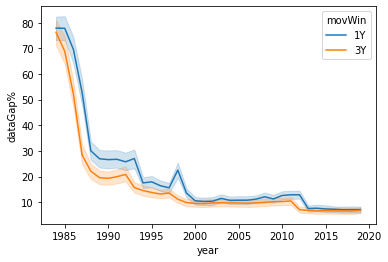

In [16]:
sns.lineplot(data=dc_df, x="year", y="dataGap%", hue="movWin")

## GEE: export data coverage /asia

In [ ]:
#ROI = ee.FeatureCollection(parcels_geojson)
ROI = ee.Geometry(parcels_geojson['features'][parcelID[11]]['geometry']).bounds()
ROI.getInfo()

{'coordinates': [[[114.25955400000001, 21.028374999999976],
   [117.343127, 21.028374999999976],
   [117.343127, 24.62050700000002],
   [114.25955400000001, 24.62050700000002],
   [114.25955400000001, 21.028374999999976]]],
 'geodesic': False,
 'type': 'Polygon'}

In [ ]:
# Load Landsat Archives
ls8 = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR") \
        .filterDate('2013', '2020') \
        .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
        .filterBounds(ROI) \
        .sort("system:time_start", True)
ls7 = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR") \
      .filterDate('1999', '2020') \
      .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
      .filterBounds(ROI) \
      .sort("system:time_start", True)
ls5 = ee.ImageCollection("LANDSAT/LT05/C01/T1_SR") \
      .filterDate('1984', '2013') \
      .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
      .filterBounds(ROI) \
      .sort("system:time_start", True)
ls4 = ee.ImageCollection("LANDSAT/LT04/C01/T1_SR") \
      .filterDate('1984', '1994') \
      .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
      .filterBounds(ROI)\
      .sort("system:time_start", True)

# Merge Collections + Mask Cloud + Add water index bands
ls_all = ls8.merge(ls7).merge(ls5).merge(ls4)
ls_all = ls_all.sort('system:time_start', True).map(maskCloud).map(addIndex)

In [ ]:
# Count Observations at pixel level by year 
years = ee.List.sequence(1984, 2019)
counts = ee.ImageCollection.fromImages(
  years.map(lambda YEAR: 
            ls_all.select(['wiFi']).filter(ee.Filter.calendarRange(YEAR,YEAR,'year')).count().clip(ROI).set({'year':YEAR})))


In [ ]:
#Map = geemap.Map(center=(20, 110), zoom=3)
#Map.addLayer(ROI, {}, 'ROI')

#vis = {'palette':["#ebedef", "#f6ddcc", "#f8c471", "#f4d03f", "#58d68d", \
#                "#27ae60", "#1abc9c", "#3498db", "#2471a3", "#6c3483"], 'min':0, 'max':29}
#Map.addLayer(counts.filter(ee.Filter.eq('year',1987)), vis, '1987')
#Map.addLayer(counts.filter(ee.Filter.eq('year',2019)), vis, '2019')
#Map

In [ ]:
#img_count = counts.toBands()
#task_config = {
#    'description': 'data_coverage_asia_1km',
#    'fileNamePrefix': 'data_coverage_asia_1km',
#    'crs': 'EPSG:4326',
#    'scale': 1000,  
#    'region': ROI.geometry(),#.getInfo()['coordinates'],
#    'folder': 'myExportImage',
#    'skipEmptyTiles': True,
#    'fileFormat': 'GeoTIFF',
#    'maxPixels': 10e12
#    }
#task = ee.batch.Export.image.toDrive(img_count, **task_config)
#task.start() 
#task2 = ee.batch.Export.image.toDrive(img_count, **task_config)
#task2.start() 


In [ ]:
#print(task.status())
#print(task2.status())